In [69]:
!pip install fuzzywuzzy

In [ ]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, GradientBoostingClassifier
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
from fuzzywuzzy import process
import sqlite3
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC

# Explore Data

In [71]:
collisions = pd.read_csv('/Users/annaywj/Desktop/SDSU/CS577/pd_collisions_datasd.csv')
traffic = pd.read_csv('/Users/annaywj/Desktop/SDSU/CS577/traffic_counts_datasd.csv')
collisions.head()

,report_id,date_time,police_beat,address_no_primary,address_pd_primary,address_road_primary,address_sfx_primary,address_pd_intersecting,address_name_intersecting,address_sfx_intersecting,violation_section,violation_type,charge_desc,injured,killed,hit_run_lvl
0,192016,2015-03-19 12:00:00,622,5200,,LINDA VISTA,ROAD,,,,MISC-HAZ,VC,MISCELLANEOUS HAZARDOUS VIOLATIONS OF THE VEHI...,0,0,MISDEMEANOR
1,190012,2015-03-24 03:05:00,626,1000,W,WASHINGTON,STREET,,,,22107,VC,TURNING MOVEMENTS AND REQUIRED SIGNALS,2,0,NaN
2,191866,2015-03-27 23:56:00,613,2800,,WORDEN,STREET,,,,22107,VC,TURNING MOVEMENTS AND REQUIRED SIGNALS,1,0,NaN
3,185207,2015-07-06 11:45:00,813,2800,,EL CAJON,BOULEVARD,,,,20002(A),VC,HIT AND RUN,0,0,MISDEMEANOR
4,1608987,2015-08-22 13:45:00,999,0,,DE ANZA POINT,,,,,MISC-HAZ,VC,MISCELLANEOUS HAZARDOUS VIOLATIONS OF THE VEHI...,1,0,NaN


In [72]:
collisions.dtypes

report_id                    object
date_time                    object
police_beat                   int64
address_no_primary            int64
address_pd_primary           object
address_road_primary         object
address_sfx_primary          object
address_pd_intersecting      object
address_name_intersecting    object
address_sfx_intersecting     object
violation_section            object
violation_type               object
charge_desc                  object
injured                       int64
killed                        int64
hit_run_lvl                  object
dtype: object

In [73]:
traffic.head()

,id,street_name,limits,northbound_count,southbound_count,eastbound_count,westbound_count,total_count,file_no,date_count
0,01AV018207,01 AV,A ST - ASH ST,18010,NaN,NaN,NaN,18010,0182-07,2007-03-13 00:00:00
1,01AV015210,01 AV,A ST - ASH ST,20060,NaN,NaN,NaN,20060,0152-10,2010-03-18 00:00:00
2,01AV018213,01 AV,A ST - ASH ST,19597,NaN,NaN,NaN,19597,0182-13,2013-03-12 00:00:00
3,01AV007721,01 AV,A ST - ASH ST,10640,NaN,NaN,NaN,10640,0077-21,2021-03-10 00:00:00
4,01AV088812,01 AV,ASH ST - BEECH ST,2298,NaN,NaN,NaN,2298,0888-12,2012-12-11 00:00:00


In [74]:
traffic.dtypes

id                   object
street_name          object
limits               object
northbound_count     object
southbound_count    float64
eastbound_count     float64
westbound_count     float64
total_count           int64
file_no              object
date_count           object
dtype: object

### Using SQL to know more about the columns

In [75]:
conn = sqlite3.connect(':memory:') 

collisions.to_sql('collisions', conn, index=False, if_exists='replace')
traffic.to_sql('traffic', conn, index=False, if_exists='replace')

cursor = conn.cursor()

cursor.execute("SELECT DISTINCT address_sfx_primary FROM collisions")
distinct_address_sfx_primary = cursor.fetchall()
distinct_address_sfx_primary

[('ROAD',),
 ('STREET',),
 ('BOULEVARD',),
 (' ',),
 ('WAY',),
 ('DRIVE',),
 ('COURT',),
 ('AVENUE',),
 ('PARKWAY',),
 ('LANE',),
 ('HIGHWAY',),
 ('PLACE',),
 ('ROW',),
 ('PLAZA',),
 ('MALL',),
 ('CIRCLE',),
 ('COVE',),
 ('DRIVEWAY',),
 ('SQUARE',),
 ('AVE',),
 ('POINT',),
 ('TERRACE',),
 ('WALK',),
 ('PASEO',),
 ('TRAIL',),
 ('KNOLLS',),
 (None,),
 ('LIGHTS',),
 ('PATH',),
 ('ALLEY',),
 ('RAMP',),
 ('CRESCENT',),
 ('EXT ST',),
 ('GLEN',),
 ('BRIDGE',),
 ('CLIFF',),
 ('INTERSTATE',)]

In [76]:
cursor.execute("SELECT DISTINCT street_name FROM traffic")
distinct_street_name = cursor.fetchall()
distinct_street_name

[('01 AV',),
 ('02 AV',),
 ('03 AV',),
 ('04 AV',),
 ('05 AV',),
 ('06 AV',),
 ('07 AV',),
 ('08 AV',),
 ('09 AV',),
 ('10 AV',),
 ('11 AV',),
 ('13 ST',),
 ('14 ST',),
 ('16 ST',),
 ('17 ST',),
 ('19 (S)  ST',),
 ('19 ST',),
 ('25 (SB)  ST',),
 ('25 ST',),
 ('26 ST',),
 ('27 ST',),
 ('28 ST',),
 ('30  ST',),
 ('30 (SB)  ST',),
 ('30 ST',),
 ('32 ST',),
 ('33  ST',),
 ('33 ST',),
 ('35 ST',),
 ('36 ST',),
 ('37 ST',),
 ('38 ST',),
 ('39 ST',),
 ('40 ST',),
 ('41 ST',),
 ('42 ST',),
 ('43 ST',),
 ('45 ST',),
 ('47  ST',),
 ('47 ST',),
 ('49 ST',),
 ('50 ST',),
 ('51 ST',),
 ('52 ST',),
 ('54 ST',),
 ('54 ST ',),
 ('55 ST',),
 ('56 ST',),
 ('58 (S)  ST',),
 ('58 ST',),
 ('60  ST',),
 ('60 ST',),
 ('61 ST',),
 ('62 ST',),
 ('63 ST',),
 ('65 AV',),
 ('65 ST',),
 ('68 ST',),
 ('69  ST',),
 ('69 ST',),
 ('70 ST',),
 ('A ST',),
 ('ABBOTT ST',),
 ('ABER ST',),
 ('ACACIA ST',),
 ('ACENA DR',),
 ('ACORN ST',),
 ('ACTIVITY RD',),
 ('ACWORTH AV',),
 ('ADAMS AV',),
 ('ADOBE FALLS RD',),
 ('ADOLPHIA

In [77]:
cursor.execute("SELECT DISTINCT hit_run_lvl FROM collisions")
distinct_hit_run_lvl = cursor.fetchall()
distinct_hit_run_lvl

[('MISDEMEANOR',), (None,), ('FELONY',)]

# Data Preprocessing

### Handling Missing Values

In [78]:
collisions = collisions.drop('address_pd_intersecting', axis=1)

In [79]:
# Create a dictionary for street types
street_type_map = {
    'AV': 'AVENUE', 'AVE': 'AVENUE', 'AVENUE': 'AVENUE',
    'ST': 'STREET', 'BL': 'BOULEVARD', 'BLVD': 'BOULEVARD',
    'RD': 'ROAD', 'HWY': 'HIGHWAY', 'LN': 'LANE', 'DR': 'DRIVE',
    'CT': 'COURT', 'PKWY': 'PARKWAY', 'TRL': 'TRAIL', 'PL': 'PLACE'
}

def standardize_street_name(street_name):
    """
    Standardizes a street name by:
    1. Removing parentheses and extra spaces.
    2. Converting to uppercase.
    3. Splitting the name into road name and street type.
    4. Using fuzzy matching for street types that are unknown.
    """
    if not isinstance(street_name, str):
        return '', 'UNKNOWN'
    
    # Clean and normalize string
    street_name = re.sub(r'\s*\(.*?\)\s*', '', street_name)  
    street_name = re.sub(r'\s+', ' ', street_name).strip()  
    street_name = street_name.upper()
    
    # Split into road name and street type
    parts = street_name.split()
    if not parts:
        return '', 'UNKNOWN'

    street_type_candidate = parts[-1]  
    road_name = ' '.join(parts[:-1])  
    street_type = street_type_map.get(street_type_candidate, 'UNKNOWN')

    # Apply fuzzy matching
    if street_type == 'UNKNOWN':
        best_match, score = process.extractOne(street_type_candidate, street_type_map.keys())
        if score >= 80:  # Filter only high-confidence matches
            street_type = street_type_map[best_match]

    return road_name, street_type

# Apply the function
traffic[['road_name', 'street_type']] = traffic['street_name'].apply(standardize_street_name).apply(pd.Series)
print(traffic[['street_name', 'road_name', 'street_type']].head())

  street_name road_name street_type
0       01 AV        01      AVENUE
1       01 AV        01      AVENUE
2       01 AV        01      AVENUE
3       01 AV        01      AVENUE
4       01 AV        01      AVENUE


In [80]:
def get_season(month):
    """
    Determine the season for a given month.
    """
    if month in [12, 1, 2]:
        return 'Winter'
    if month in [3, 4, 5]:
        return 'Spring'
    if month in [6, 7, 8]:
        return 'Summer'
    return 'Fall'

In [81]:
def create_full_address(row):
    """
    Create a full address by combining roads and intersections.
    """
    primary = f"{row['address_no_primary']} {row['address_road_primary']} {row['address_sfx_primary']}".strip()
    if pd.notna(row['address_name_intersecting']) and pd.notna(row['address_sfx_intersecting']):
        return f"{primary} & {row['address_name_intersecting']} {row['address_sfx_intersecting']}".strip()
    return primary

In [82]:
# Clean direction columns
direction_columns = ['northbound_count', 'eastbound_count', 'southbound_count', 'westbound_count']

traffic[direction_columns] = traffic[direction_columns].replace(r'^\s*$', np.nan, regex=True)
traffic[direction_columns] = traffic[direction_columns].apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)

### Convert date

In [83]:
# Convert date_count to datetime
traffic['date_count'] = pd.to_datetime(traffic['date_count'], errors='coerce')
collisions['date_time'] = pd.to_datetime(collisions['date_time'])

In [84]:
collisions['date_time'] = pd.to_datetime(collisions['date_time'])
traffic['date_count'] = pd.to_datetime(traffic['date_count'], errors='coerce')

collisions['date'] = collisions['date_time'].dt.date
collisions['hour'] = collisions['date_time'].dt.hour
collisions['day'] = collisions['date_time'].dt.day
collisions['month'] = collisions['date_time'].dt.month
collisions['season'] = collisions['month'].apply(get_season)

traffic['road_name'], traffic['street_type'] = zip(*traffic['street_name'].apply(standardize_street_name))
traffic = traffic.dropna(subset=['date_count'])
collisions['full_address'] = collisions.apply(create_full_address, axis=1)

In [85]:
collisions['hit_run_lvl'] = collisions['hit_run_lvl'].fillna('UNKNOWN')
collisions = collisions.dropna(subset=['address_road_primary', 'address_sfx_primary', 'address_name_intersecting', 'address_sfx_intersecting'])

### Convert to Categorical

In [86]:
collisions['address_sfx_primary'] = collisions['address_sfx_primary'].astype('category')
collisions['address_name_intersecting'] = collisions['address_name_intersecting'].astype('category')
collisions['address_sfx_intersecting'] = collisions['address_sfx_intersecting'].astype('category')
collisions['violation_section'] = collisions['violation_section'].astype('category')
collisions['violation_type'] = collisions['violation_type'].astype('category')
collisions['hit_run_lvl'] = collisions['hit_run_lvl'].fillna('UNKNOWN').astype('category')

### Feature Enginnering

In [87]:
collisions['severity'] = collisions['injured'] + collisions['killed']
traffic['total_count'] = traffic[direction_columns].sum(axis=1)

# EDA

### Visusalize Accidents Frequency

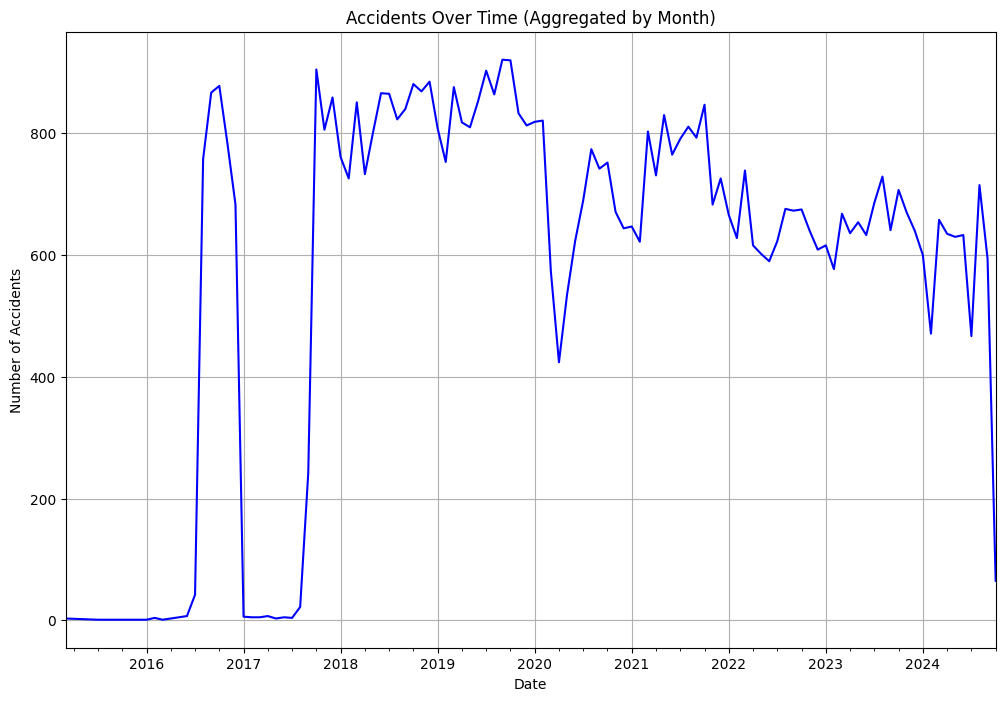

In [88]:
# Group by month
collisions['month'] = pd.to_datetime(collisions['date_time']).dt.to_period('M')
accidents_per_month = collisions.groupby('month').size()

plt.figure(figsize=(12, 8))
accidents_per_month.plot(kind='line', color='blue')
plt.title('Accidents Over Time (Aggregated by Month)')
plt.xlabel('Date')
plt.ylabel('Number of Accidents')
plt.grid(True)
plt.show()

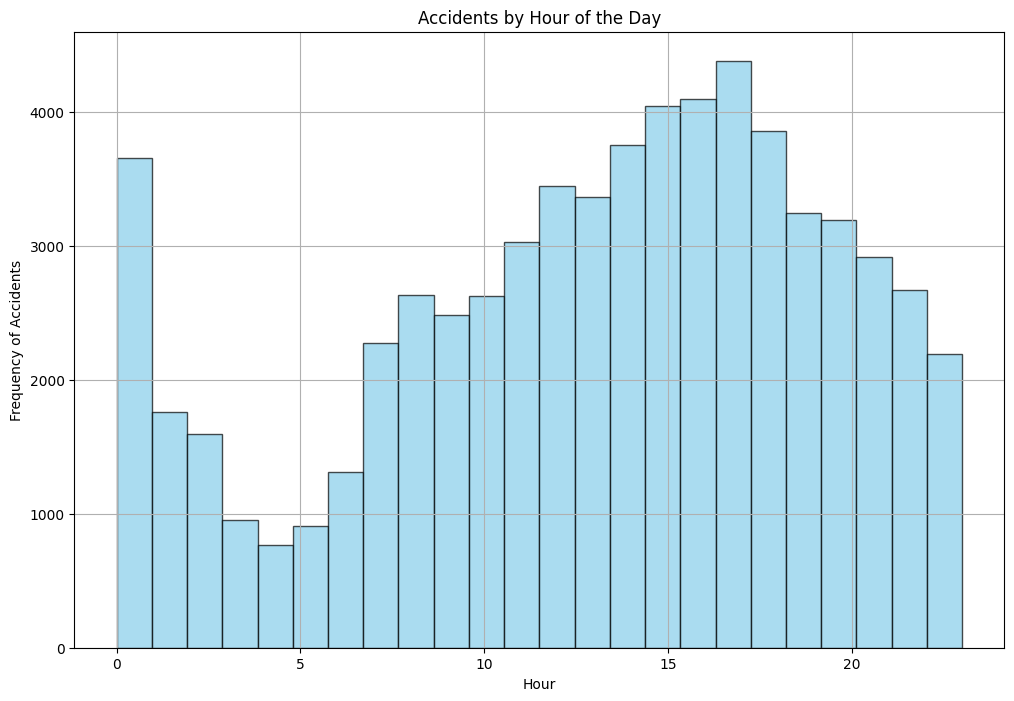

In [89]:
# Accident by time of the day
plt.figure(figsize=(12, 8))
collisions['hour'].plot(kind='hist', bins=24, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Accidents by Hour of the Day')
plt.xlabel('Hour')
plt.ylabel('Frequency of Accidents')
plt.grid(True)
plt.show()

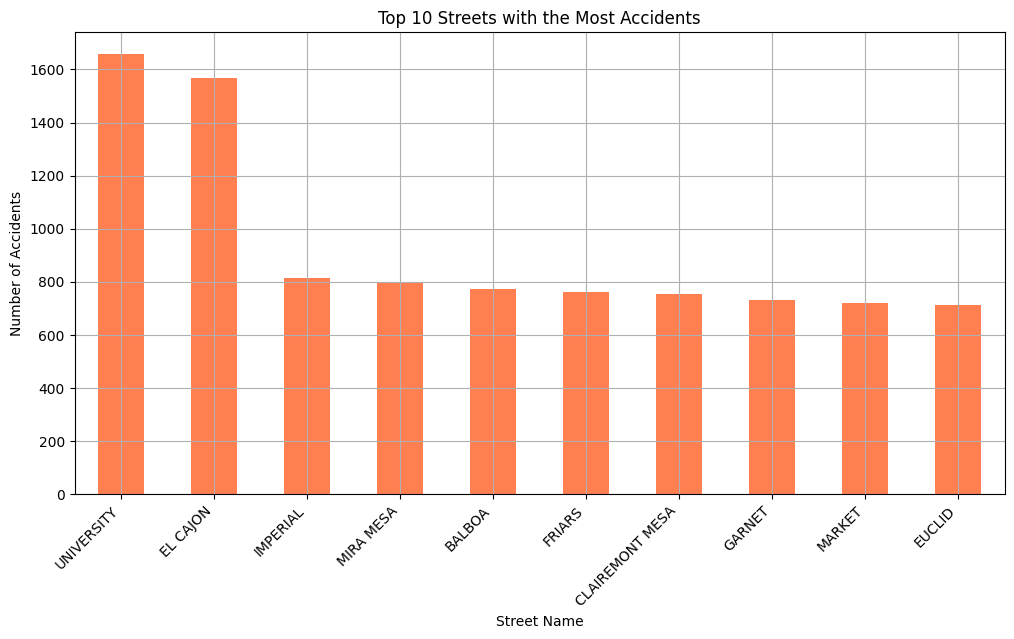

In [90]:
# Accidents by Roads and Intersections
top_roads = collisions['address_road_primary'].value_counts().head(10)
plt.figure(figsize=(12, 6))
top_roads.plot(kind='bar', color='coral')
plt.title('Top 10 Streets with the Most Accidents')
plt.xlabel('Street Name')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()

### Injuries and Killed

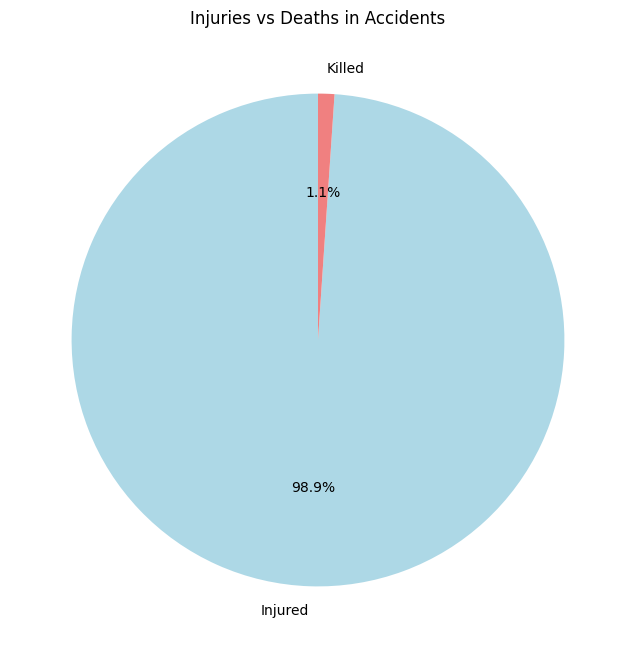

In [91]:
# Injuries vs killed in accidents
injuries_total = collisions['injured'].sum()
deaths_total = collisions['killed'].sum()
injuries_vs_deaths = [injuries_total, deaths_total]

fig, ax = plt.subplots(figsize=(8, 8), facecolor='white') 
ax.set_facecolor('white') 
ax.pie(injuries_vs_deaths, labels=['Injured', 'Killed'], autopct='%1.1f%%', 
       colors=['lightblue', 'lightcoral'], startangle=90, textprops={'color':'black'})
ax.set_title('Injuries vs Deaths in Accidents', color='black')
plt.show()

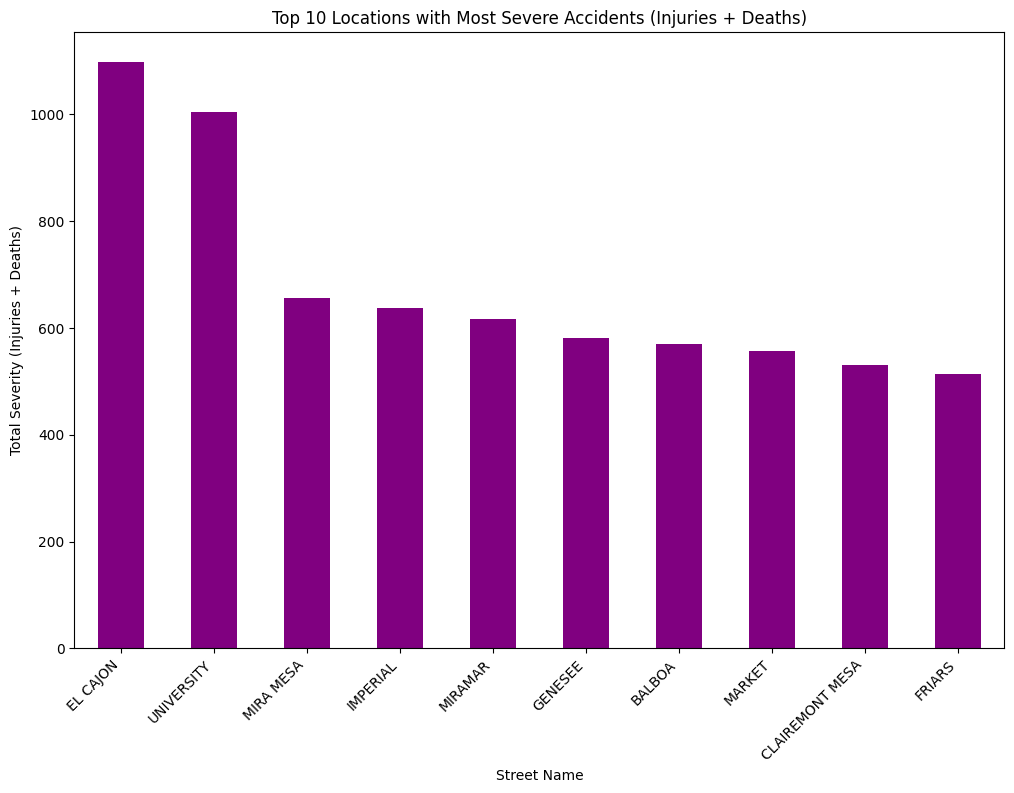

In [92]:
# Where do most severe accidents occur?
collisions['severity'] = collisions['injured'] + collisions['killed']
top_severe_locations = collisions.groupby('address_road_primary')['severity'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 8))
top_severe_locations.plot(kind='bar', color='purple')
plt.title('Top 10 Locations with Most Severe Accidents (Injuries + Deaths)')
plt.xlabel('Street Name')
plt.ylabel('Total Severity (Injuries + Deaths)')
plt.xticks(rotation=45, ha='right')
plt.show()

/var/folders/4k/gkr388115hjbdbj5xzxdyy9h0000gn/T/ipykernel_21228/3464488088.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  violations_injuries_deaths = collisions.groupby('violation_type')[['injured', 'killed']].sum()


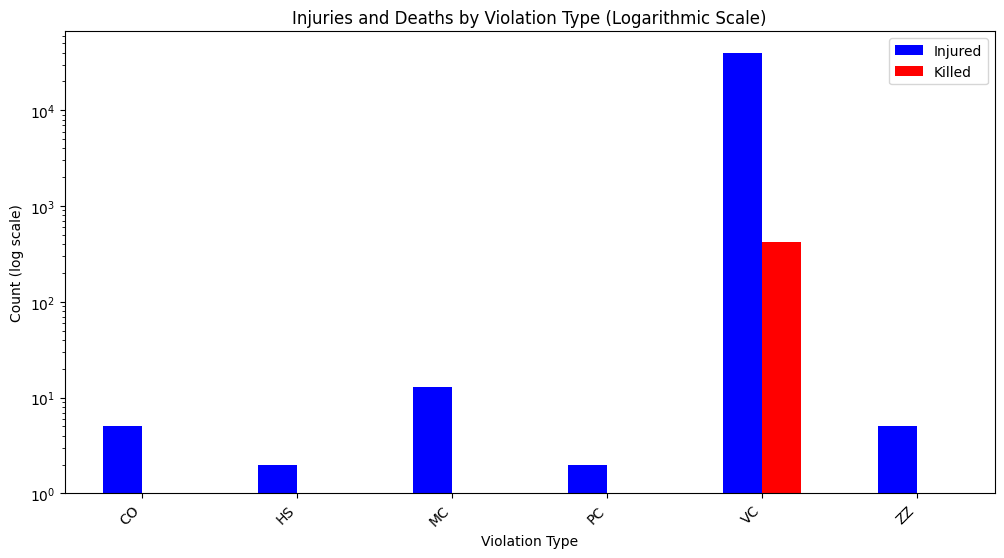

In [93]:
# Injuries and Fatatilities by Violation Types
violations_injuries_deaths = collisions.groupby('violation_type')[['injured', 'killed']].sum()

violations_injuries_deaths.plot(kind='bar', figsize=(12, 6), color=['blue', 'red'], log=True)
plt.title('Injuries and Deaths by Violation Type (Logarithmic Scale)')
plt.xlabel('Violation Type')
plt.ylabel('Count (log scale)')
plt.xticks(rotation=45, ha='right')
plt.legend(['Injured', 'Killed'])
plt.show()

### Time-based

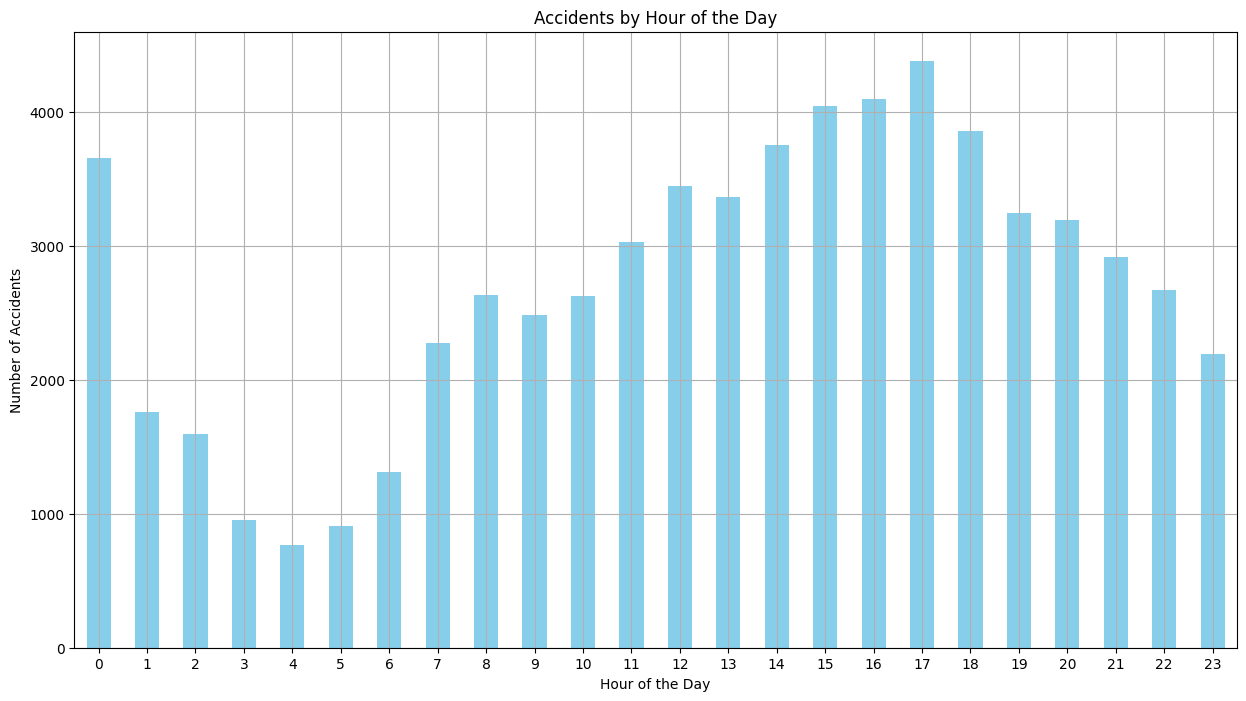

In [94]:
# Group by hour and count the number of accidents
accidents_by_hour = collisions.groupby('hour').size()

plt.figure(figsize=(15, 8))
accidents_by_hour.plot(kind='bar', color='skyblue')
plt.title('Accidents by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

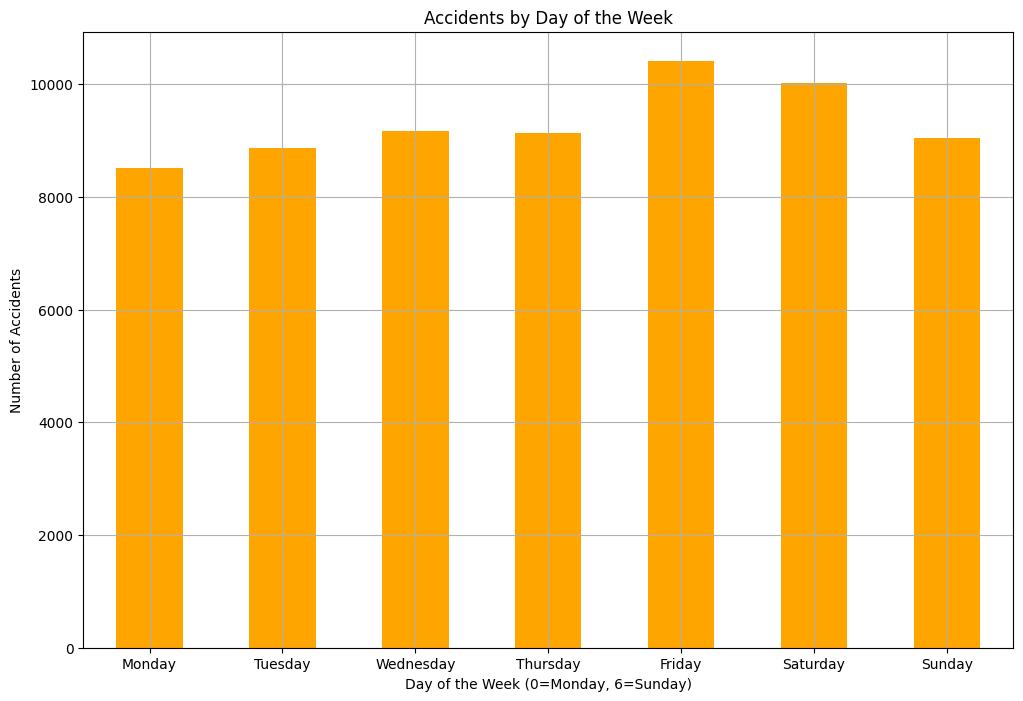

In [95]:
# Accidents by Day of the Week
collisions['day_of_week'] = pd.to_datetime(collisions['date_time']).dt.dayofweek
accidents_by_day = collisions.groupby('day_of_week').size()

plt.figure(figsize=(12, 8))
accidents_by_day.plot(kind='bar', color='orange')
plt.title('Accidents by Day of the Week')
plt.xlabel('Day of the Week (0=Monday, 6=Sunday)')
plt.ylabel('Number of Accidents')
plt.xticks(ticks=range(7), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=0)
plt.grid(True)
plt.show()

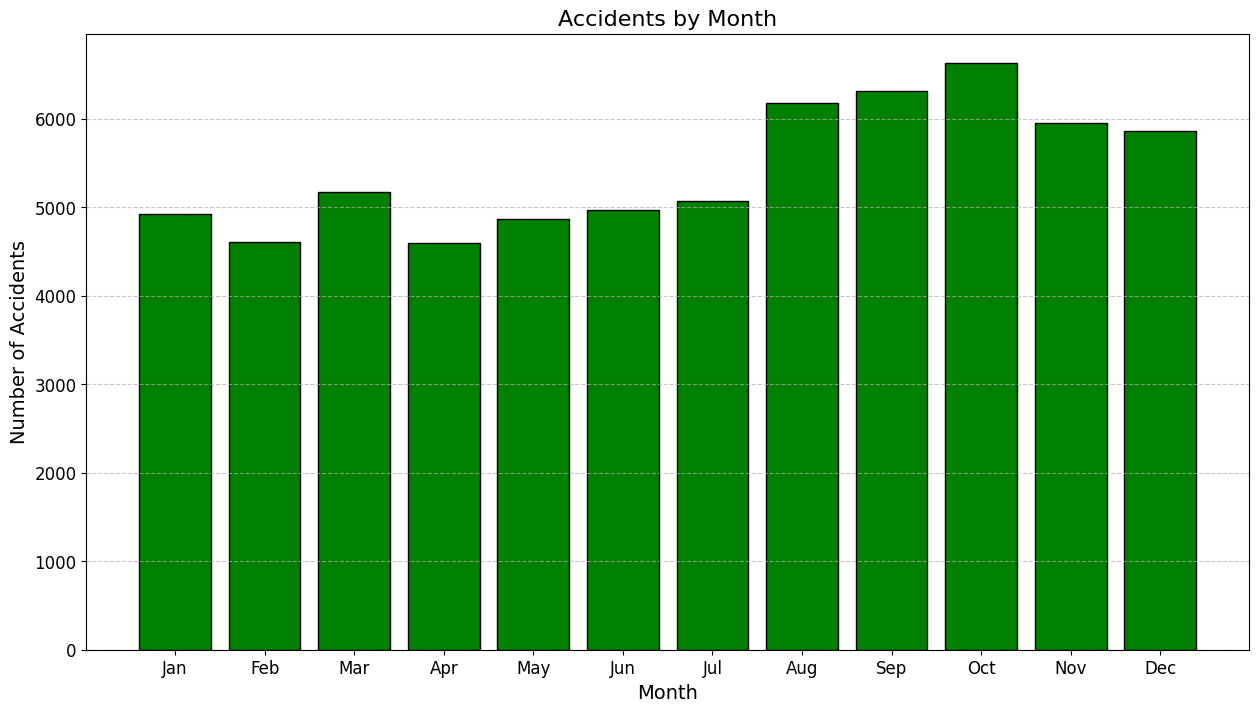

In [96]:
collisions['month'] = collisions['date_time'].dt.month
accidents_by_month = collisions['month'].value_counts().sort_index() 

# Define months
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig, ax = plt.subplots(figsize=(15, 8), facecolor='white')
ax.set_facecolor('white')
ax.bar(months, accidents_by_month, color='green', edgecolor='black')  
ax.set_xlabel('Month', fontsize=14)
ax.set_ylabel('Number of Accidents', fontsize=14)
ax.set_title('Accidents by Month', fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()


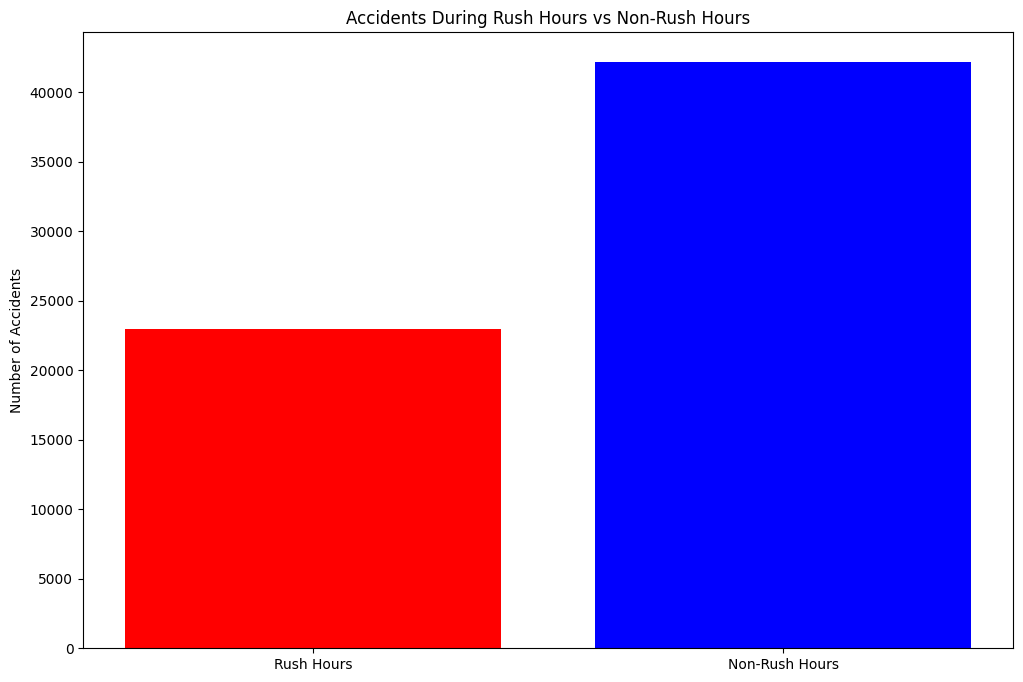

In [97]:
# Rush hour (7-9 AM, 4-7 PM) vs. non-rush hour Accidents
rush_hours = (collisions['hour'].between(7, 9)) | (collisions['hour'].between(16, 19))
rush_hour_accidents = collisions[rush_hours].shape[0]
non_rush_hour_accidents = collisions[~rush_hours].shape[0]

plt.figure(figsize=(12, 8))
plt.bar(['Rush Hours', 'Non-Rush Hours'], [rush_hour_accidents, non_rush_hour_accidents], color=['red', 'blue'])
plt.title('Accidents During Rush Hours vs Non-Rush Hours')
plt.ylabel('Number of Accidents')
plt.show()

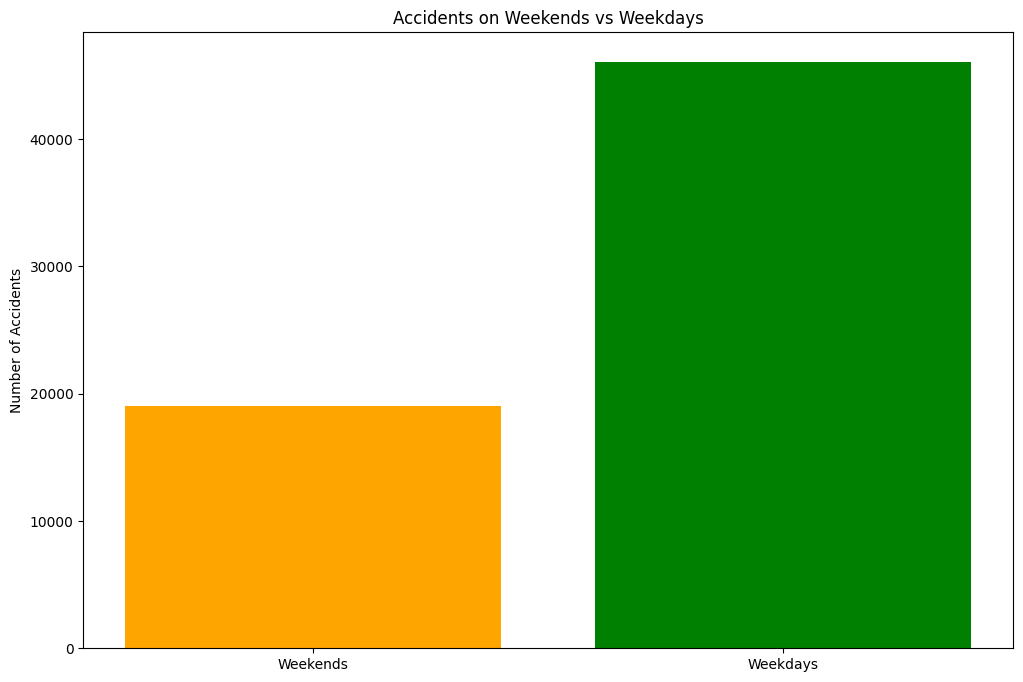

In [98]:
# Weekend vs. weekday accidents(Saturday=5, Sunday=6)
collisions['is_weekend'] = collisions['day_of_week'].isin([5, 6])
weekend_accidents = collisions[collisions['is_weekend']].shape[0]
weekday_accidents = collisions[~collisions['is_weekend']].shape[0]

plt.figure(figsize=(12, 8))
plt.bar(['Weekends', 'Weekdays'], [weekend_accidents, weekday_accidents], color=['orange', 'green'])
plt.title('Accidents on Weekends vs Weekdays')
plt.ylabel('Number of Accidents')
plt.show()

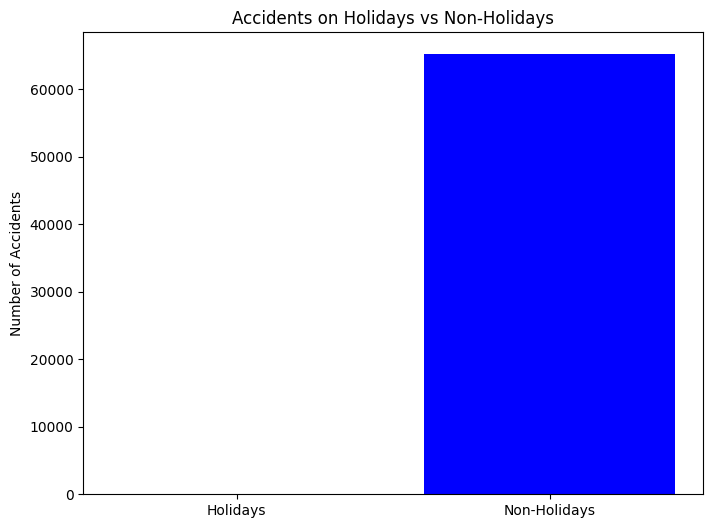

In [99]:
# holiday vs non-holiday accidents
holidays = calendar().holidays(start=collisions['date_time'].min(), end=collisions['date_time'].max())
collisions['is_holiday'] = collisions['date_time'].dt.date.isin(holidays)
holiday_accidents = collisions[collisions['is_holiday']].shape[0]
non_holiday_accidents = collisions[~collisions['is_holiday']].shape[0]

plt.figure(figsize=(8, 6))
plt.bar(['Holidays', 'Non-Holidays'], [holiday_accidents, non_holiday_accidents], color=['gold', 'blue'])
plt.title('Accidents on Holidays vs Non-Holidays')
plt.ylabel('Number of Accidents')
plt.show()

In [100]:
cal = calendar()
holidays = cal.holidays(start='2020-01-01', end='2023-12-31')
print(holidays)

DatetimeIndex(['2020-01-01', '2020-01-20', '2020-02-17', '2020-05-25',
               '2020-07-03', '2020-09-07', '2020-10-12', '2020-11-11',
               '2020-11-26', '2020-12-25', '2021-01-01', '2021-01-18',
               '2021-02-15', '2021-05-31', '2021-06-18', '2021-07-05',
               '2021-09-06', '2021-10-11', '2021-11-11', '2021-11-25',
               '2021-12-24', '2021-12-31', '2022-01-17', '2022-02-21',
               '2022-05-30', '2022-06-20', '2022-07-04', '2022-09-05',
               '2022-10-10', '2022-11-11', '2022-11-24', '2022-12-26',
               '2023-01-02', '2023-01-16', '2023-02-20', '2023-05-29',
               '2023-06-19', '2023-07-04', '2023-09-04', '2023-10-09',
               '2023-11-10', '2023-11-23', '2023-12-25'],
              dtype='datetime64[ns]', freq=None)


In [101]:
collisions['date'] = pd.to_datetime(collisions['date'])
holidays = pd.to_datetime(holidays)
collisions['is_holiday'] = collisions['date'].isin(holidays)
collisions['is_holiday'].value_counts()

is_holiday
False    64292
True       866
Name: count, dtype: int64

Average accidents per holiday: 20.14
Average accidents per non-holiday: 23.09


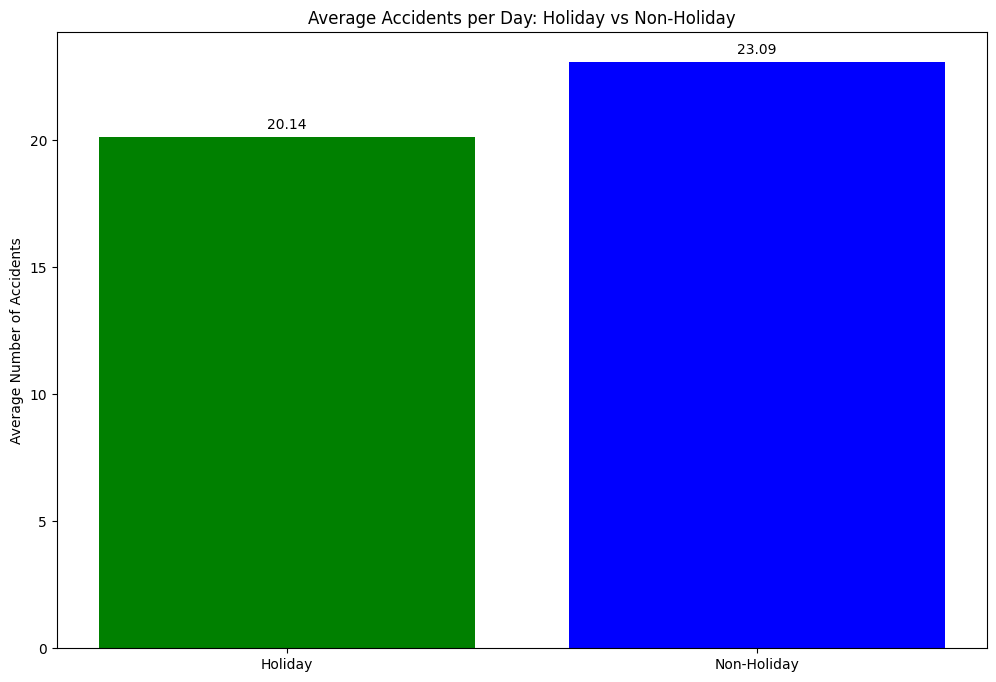

In [102]:

# Count the total number of accidents on holidays and non-holidays
total_holiday_accidents = collisions[collisions['is_holiday'] == True].shape[0]
total_non_holiday_accidents = collisions[collisions['is_holiday'] == False].shape[0]

# Calculate total days
total_days = collisions['date'].nunique()
total_holiday_days = len(holidays)
total_non_holiday_days = total_days - total_holiday_days

# Calculate and round the average accidents per holiday and non-holiday
if total_holiday_days > 0:  # Avoid division by zero
    average_holiday_accidents = round(total_holiday_accidents / total_holiday_days, 2)
else:
    average_holiday_accidents = 0

if total_non_holiday_days > 0:  # Avoid division by zero
    average_non_holiday_accidents = round(total_non_holiday_accidents / total_non_holiday_days, 2)
else:
    average_non_holiday_accidents = 0

print("Average accidents per holiday: " + str(average_holiday_accidents))
print("Average accidents per non-holiday: " + str(average_non_holiday_accidents))

# Prepare data for plotting
avg_accidents = [average_holiday_accidents, average_non_holiday_accidents]

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
bars = ax.bar(['Holiday', 'Non-Holiday'], avg_accidents, color=['green', 'blue'])
ax.bar_label(bars, labels=[f'{round(val, 2)}' for val in avg_accidents], padding=3)
ax.set_title('Average Accidents per Day: Holiday vs Non-Holiday')
ax.set_ylabel('Average Number of Accidents')
plt.show()


### Hotspots

/var/folders/4k/gkr388115hjbdbj5xzxdyy9h0000gn/T/ipykernel_21228/2773244456.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  accidents_by_intersection = collisions.groupby(['address_road_primary', 'address_name_intersecting']).size().sort_values(ascending=False)


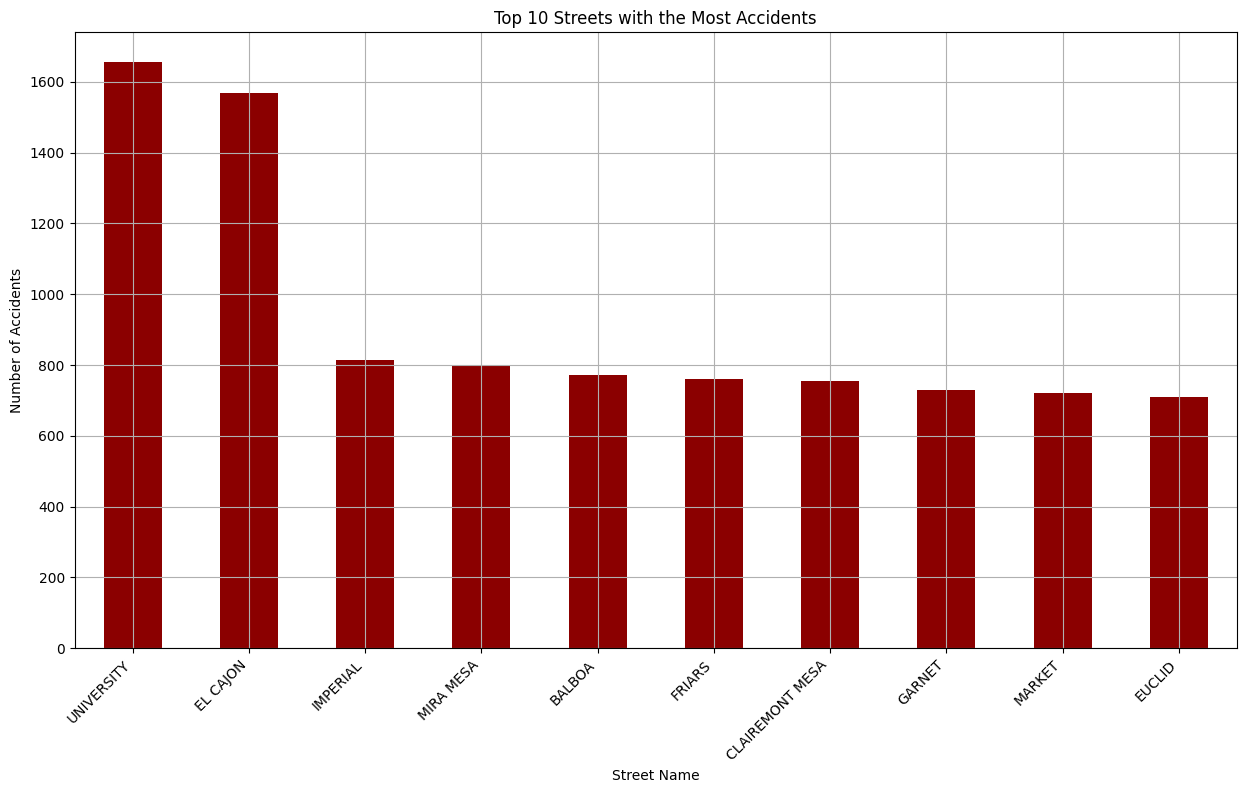

In [103]:
# Group by street 
accidents_by_street = collisions.groupby('address_road_primary').size().sort_values(ascending=False)
# Group by intersections
accidents_by_intersection = collisions.groupby(['address_road_primary', 'address_name_intersecting']).size().sort_values(ascending=False)

# Top 10 streets with the most accidents
top_streets = accidents_by_street.head(10)
plt.figure(figsize=(15, 8))
top_streets.plot(kind='bar', color='darkred')
plt.title('Top 10 Streets with the Most Accidents')
plt.xlabel('Street Name')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()

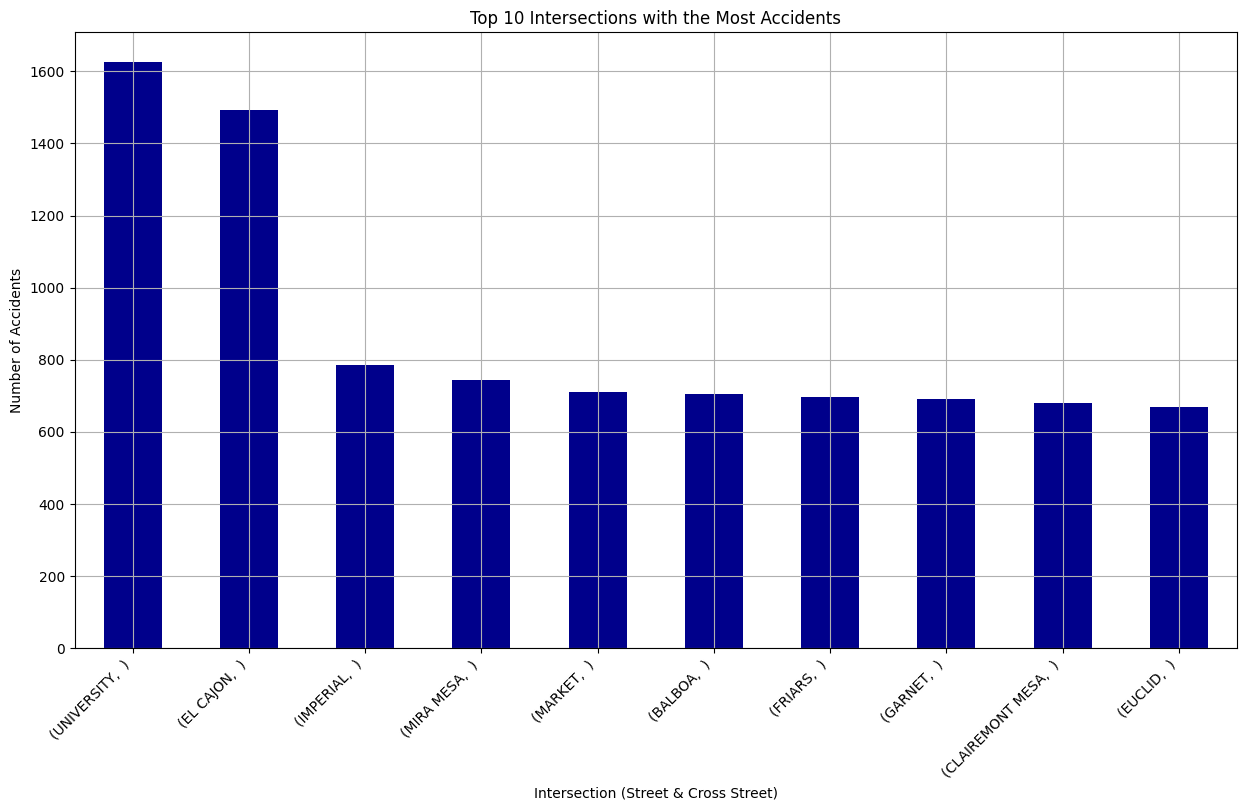

In [104]:
# Top 10 intersections with the most accidents
top_intersections = accidents_by_intersection.head(10)

plt.figure(figsize=(15, 8))
top_intersections.plot(kind='bar', color='darkblue')
plt.title('Top 10 Intersections with the Most Accidents')
plt.xlabel('Intersection (Street & Cross Street)')
plt.ylabel('Number of Accidents')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()

# Correlating Traffic Volume and Accident Data

In [105]:
collisions['date'] = pd.to_datetime(collisions['date'])
traffic['date_count'] = pd.to_datetime(traffic['date_count'])

# Merge the datasets
df = pd.merge(collisions, traffic, left_on='date', right_on='date_count', how='inner')
df['total_count'] = df[['northbound_count', 'southbound_count', 'eastbound_count', 'westbound_count']].sum(axis=1)

In [106]:
accidents_by_road = df.groupby('address_road_primary').size()
traffic_volume_by_road = df.groupby('address_road_primary')['total_count'].sum()

# Merge accidents and traffic volume into one DataFrame
road_data = pd.DataFrame({
    'accidents': accidents_by_road,
    'traffic_volume': traffic_volume_by_road
})

road_data.head()

,accidents,traffic_volume
address_road_primary,,
01,1,11166
01-16-2020,2,29458
01ST,436,5357067
02ND,95,1176785
03RD,156,1943662


In [107]:
scaler = MinMaxScaler()

# Normalization
road_data[['accidents_normalized', 'traffic_volume_normalized']] = scaler.fit_transform(road_data[['accidents', 'traffic_volume']])

road_data.head()

,accidents,traffic_volume,accidents_normalized,traffic_volume_normalized
address_road_primary,,,,
01,1,11166,0.000000,0.000454
01-16-2020,2,29458,0.000496,0.001252
01ST,436,5357067,0.215667,0.233841
02ND,95,1176785,0.046604,0.051341
03RD,156,1943662,0.076847,0.084821


In [108]:
# Calculate the accident rate per unit of traffic volume (as risk factor)
road_data['risk_factor'] = road_data['accidents'] / road_data['traffic_volume']

# Replace infinity values with NaN
road_data['risk_factor'].replace([float('inf'), -float('inf')], pd.NA, inplace=True)
road_data[['accidents', 'traffic_volume', 'risk_factor']].head()

/var/folders/4k/gkr388115hjbdbj5xzxdyy9h0000gn/T/ipykernel_21228/299731582.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  road_data['risk_factor'].replace([float('inf'), -float('inf')], pd.NA, inplace=True)


,accidents,traffic_volume,risk_factor
address_road_primary,,,
01,1,11166,0.000090
01-16-2020,2,29458,0.000068
01ST,436,5357067,0.000081
02ND,95,1176785,0.000081
03RD,156,1943662,0.000080


In [109]:
# Sort the data by risk factor
high_risk_roads = road_data.sort_values(by='risk_factor', ascending=False)

# Top 10 high-risk roads
high_risk_roads.head(10)

,accidents,traffic_volume,accidents_normalized,traffic_volume_normalized,risk_factor
address_road_primary,,,,,
TRINIDAD,1,775,0.000000,0.000000,0.001290
3OTH,1,895,0.000000,0.000005,0.001117
OLIVEWOOD,1,895,0.000000,0.000005,0.001117
BENFIELD,1,895,0.000000,0.000005,0.001117
WALKING PATH,1,1028,0.000000,0.000011,0.000973
THELBORN,1,1028,0.000000,0.000011,0.000973
CHARING,1,1210,0.000000,0.000019,0.000826
CAMINO SAN FERMIN,1,1277,0.000000,0.000022,0.000783
COLEMAN,2,2932,0.000496,0.000094,0.000682


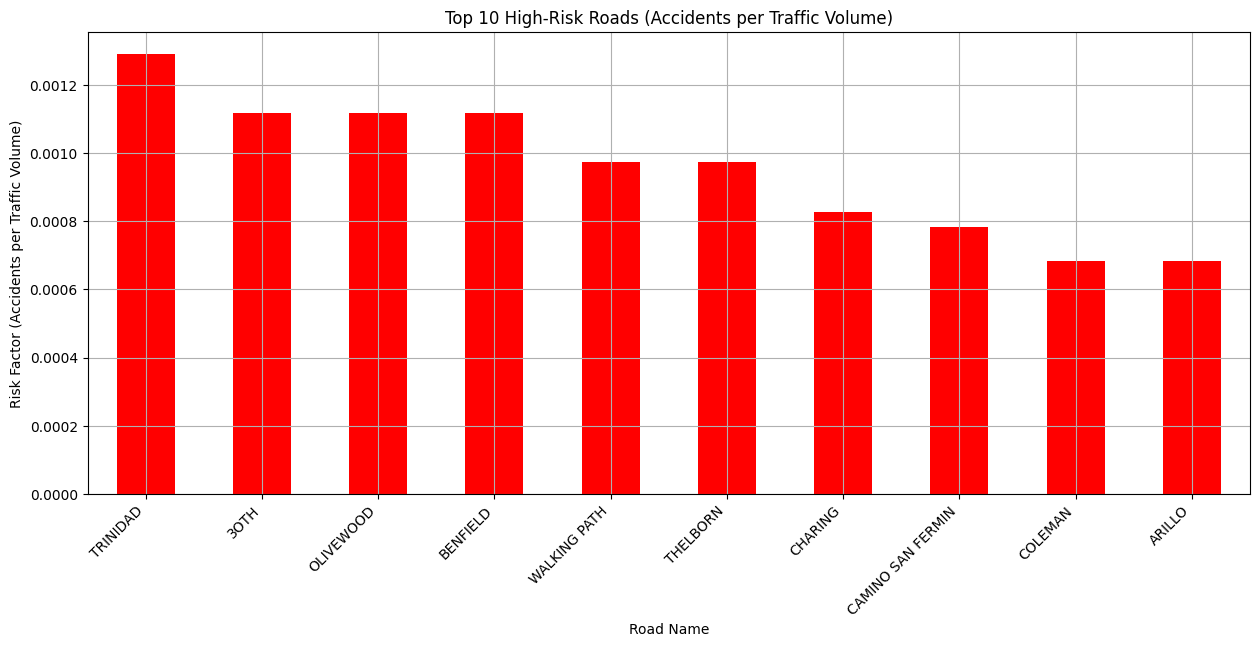

In [110]:
# Top 10 high-risk roads
plt.figure(figsize=(15, 6))
high_risk_roads['risk_factor'].head(10).plot(kind='bar', color='red')
plt.title('Top 10 High-Risk Roads (Accidents per Traffic Volume)')
plt.xlabel('Road Name')
plt.ylabel('Risk Factor (Accidents per Traffic Volume)')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()

/var/folders/4k/gkr388115hjbdbj5xzxdyy9h0000gn/T/ipykernel_21228/1622157854.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_data = df.groupby('volume_bins')['num_accidents'].mean().reset_index()


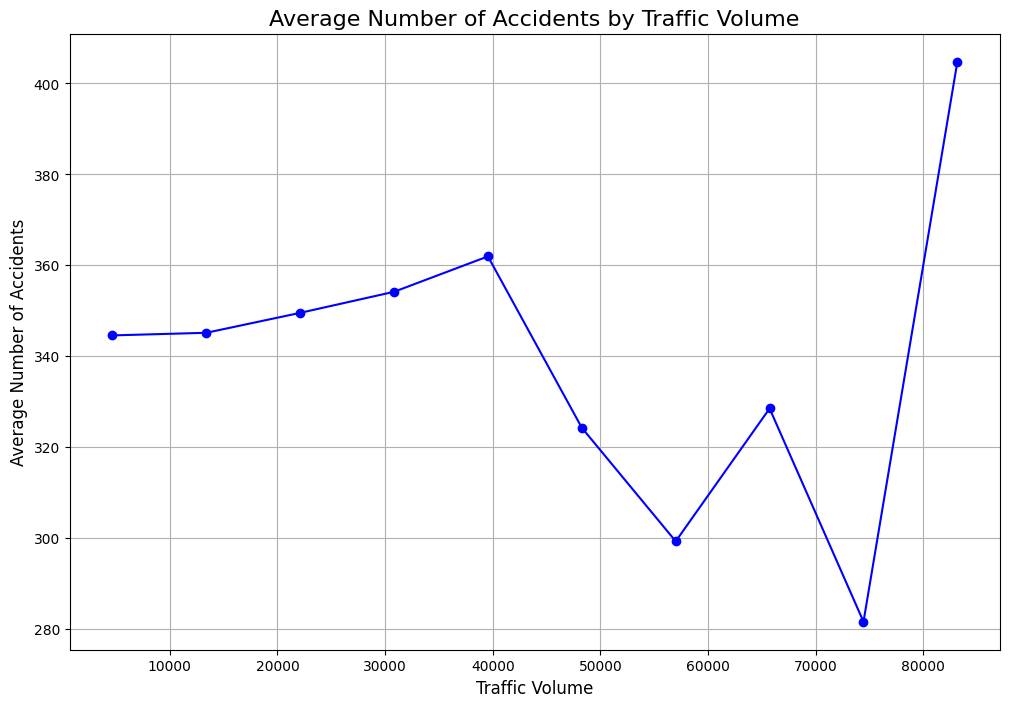

In [111]:
df['num_accidents'] = df.groupby('address_road_primary')['report_id'].transform('count')
df['volume_bins'] = pd.cut(df['total_count'], bins=10)
binned_data = df.groupby('volume_bins')['num_accidents'].mean().reset_index()
binned_data['bin_midpoints'] = binned_data['volume_bins'].apply(lambda x: x.mid)

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(binned_data['bin_midpoints'], binned_data['num_accidents'], color='blue', marker='o')
ax.set_title('Average Number of Accidents by Traffic Volume', fontsize=16)
ax.set_xlabel('Traffic Volume', fontsize=12)
ax.set_ylabel('Average Number of Accidents', fontsize=12)
plt.grid(True)
plt.show()

# Predictive Modeling: Identify Future Hotspots

In [112]:
results_summary = []

In [ ]:
df['high_severity'] = (df['severity'] >= 3).astype(int)  # Binary target for high severity
features = ['total_count', 'hour', 'month', 'day_of_week', 'is_weekend', 'is_holiday']
X = df[features]
y = df['high_severity']

In [ ]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

### Random Forest

In [ ]:
# 1. Random Forest
rf_model = RandomForestClassifier(random_state=42)
cv_scores_rf = cross_val_score(rf_model, X_resampled, y_resampled, cv=3, scoring='f1_macro')
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
f1_rf = f1_score(y_test, y_pred_rf, average='macro')
results_summary.append({'Model': 'Random Forest', 'Mean CV F1 Score': cv_scores_rf.mean(), 'Test F1 Score': f1_rf})

Cross-validation scores: [0.49202424 0.4902723  0.49021779 0.49286156 0.49127954]
Mean cross-validation score: 0.4913 ± 0.0010
Test F1 Score: 0.5047


### Gradient Boosting

In [ ]:
# 2. Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=42)
cv_scores_gb = cross_val_score(gb_model, X_resampled, y_resampled, cv=3, scoring='f1_macro')
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
f1_gb = f1_score(y_test, y_pred_gb, average='macro')
results_summary.append({'Model': 'Gradient Boosting', 'Mean CV F1 Score': cv_scores_gb.mean(), 'Test F1 Score': f1_gb})

Cross-validation scores: [0.49288314 0.49288314 0.49260283 0.49288314 0.49288314]
Mean cross-validation score: 0.4928 ± 0.0001
Test F1 Score: 0.4930


### Support Vector Machine (SVC)

In [ ]:
# 3. Support Vector Machine (SVC)
svc_model = SVC(random_state=42)
cv_scores_svc = cross_val_score(svc_model, X_resampled, y_resampled, cv=3, scoring='f1_macro')
svc_model.fit(X_train, y_train)
y_pred_svc = svc_model.predict(X_test)
f1_svc = f1_score(y_test, y_pred_svc, average='macro')
results_summary.append({'Model': 'Support Vector Machine', 'Mean CV F1 Score': cv_scores_svc.mean(), 'Test F1 Score': f1_svc})

Cross-validation scores: [0.49289962 0.49289962 0.49289962 0.49288314 0.49288314]
Mean cross-validation score: 0.4929 ± 0.0000
Test F1 Score: 0.4930


### Logistic Regression

In [ ]:
# 4. Logistic Regression Model
lr_model = LogisticRegression(random_state=42, max_iter=1000)
cv_scores_lr = cross_val_score(lr_model, X_resampled, y_resampled, cv=3, scoring='f1_macro')
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
f1_lr = f1_score(y_test, y_pred_lr, average='macro')
results_summary.append({'Model': 'Logistic Regression', 'Mean CV F1 Score': cv_scores_lr.mean(), 'Test F1 Score': f1_lr})

Cross-validation scores: [0.49289962 0.49289962 0.49289962 0.49288314 0.49288314]
Mean cross-validation score: 0.4929 ± 0.0000
Test F1 Score: 0.4930


In [ ]:
results_df = pd.DataFrame(results_summary)
results_df.sort_values(by='Mean CV F1 Score', ascending=True)

,Model,Mean CV F1 Score,Test F1 Score
4,Gradient Boosting (Tuned),0.507110,0.493789
2,Support Vector Machine,0.492893,0.493031
3,Logistic Regression,0.492893,0.493031
1,Gradient Boosting,0.492827,0.493031
0,Random Forest,0.491331,0.504677


### Hyperparameter Tuning

In [145]:
### Add New Features
X_resampled['is_peak_hour'] = ((X_resampled['hour'] >= 7) & (X_resampled['hour'] <= 9)) | ((X_resampled['hour'] >= 16) & (X_resampled['hour'] <= 19))
X_resampled['is_night'] = (X_resampled['hour'] >= 20) | (X_resampled['hour'] <= 6)

X_test['is_peak_hour'] = ((X_test['hour'] >= 7) & (X_test['hour'] <= 9)) | ((X_test['hour'] >= 16) & (X_test['hour'] <= 19))
X_test['is_night'] = (X_test['hour'] >= 20) | (X_test['hour'] <= 6)
X_resampled.head()

,total_count,hour,month,day_of_week,is_weekend,is_holiday,is_peak_hour,is_night
0,1976,13,8,5,True,False,False,False
1,24360,19,6,3,False,False,True,False
2,3271,19,6,3,False,False,True,False
3,5859,19,6,3,False,False,True,False
4,6698,19,6,3,False,False,True,False


In [ ]:
rf_model = RandomForestClassifier(random_state=42, class_weight='balanced')

# CV
cv_scores_rf = cross_val_score(rf_model, X_resampled, y_resampled, cv=3, scoring='f1_macro')
print(f"\nRandom Forest Mean CV F1 Score (after addressing imbalance): {cv_scores_rf.mean():.4f}")

rf_model.fit(X_resampled, y_resampled)
y_pred_rf = rf_model.predict(X_test)
f1_rf = f1_score(y_test, y_pred_rf, average='macro')

print("\nRandom Forest Evaluation on Test Data:")
print(f"Test F1 Score: {f1_rf:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

In [147]:
# Random Forest
param_dist_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

random_search_rf = RandomizedSearchCV(RandomForestClassifier(random_state=42),
                                      param_distributions=param_dist_rf,
                                      n_iter=20, cv=3, scoring='f1_macro', random_state=42)
random_search_rf.fit(X_resampled, y_resampled)
best_rf_model = random_search_rf.best_estimator_
y_pred_best_rf = best_rf_model.predict(X_test)
f1_best_rf = f1_score(y_test, y_pred_best_rf, average='macro')
results_summary.append({'Model': 'Random Forest (Tuned)', 'Mean CV F1 Score': random_search_rf.best_score_, 'Test F1 Score': f1_best_rf})

In [148]:
# Gradient Boosting
param_dist_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_search_gb = RandomizedSearchCV(GradientBoostingClassifier(random_state=42),
                                      param_distributions=param_dist_gb,
                                      n_iter=20, cv=3, scoring='f1_macro', random_state=42)
random_search_gb.fit(X_resampled, y_resampled)
best_gb_model = random_search_gb.best_estimator_
y_pred_best_gb = best_gb_model.predict(X_test)
f1_best_gb = f1_score(y_test, y_pred_best_gb, average='macro')
results_summary.append({'Model': 'Gradient Boosting (Tuned)', 'Mean CV F1 Score': random_search_gb.best_score_, 'Test F1 Score': f1_best_gb})

In [149]:
# Threshold
y_probs_rf = best_rf_model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_probs_rf)
best_threshold = thresholds[recall.argmax()]
y_pred_custom = (y_probs_rf >= best_threshold).astype(int)

In [150]:
# Stacking Classifier
stacked_model = StackingClassifier(
    estimators=[
        ('rf', best_rf_model),
        ('gb', GradientBoostingClassifier(random_state=42))
    ],
    final_estimator=LogisticRegression()
)
stacked_model.fit(X_resampled, y_resampled)
y_pred_stacked = stacked_model.predict(X_test)

# Result

In [151]:
# Evaluate
results = {
    'Random Forest (Tuned)': f1_score(y_test, best_rf_model.predict(X_test), average='macro'),
    'Custom Threshold RF': f1_score(y_test, y_pred_custom, average='macro'),
    'Stacking Classifier': f1_score(y_test, y_pred_stacked, average='macro')
}

pd.DataFrame.from_dict(results, orient='index', columns=['F1 Score']).sort_values(by='F1 Score', ascending=False)

,F1 Score
Random Forest (Tuned),0.942033
Stacking Classifier,0.932744
Custom Threshold RF,0.334868
